# SALES PREDICTION USING ARIMA AND PROPHET FOR BRAZILIAN E-COMMERCE

The dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

**What is ARIMA model?**

A. ARIMA(Auto Regressive Integrated Moving Average) is a combination of 2 models AR(Auto Regressive) & MA(Moving Average). It has 3 hyperparameters - P(auto regressive lags),d(order of differentiation),Q(moving avg.) which respectively comes from the AR, I & MA components. The AR part is correlation between prev & current time periods. To smooth out the noise, the MA part is used. The I part binds together the AR & MA parts.

# 📤 IMPORT LIBRARIES

In [1]:
!pip install statsmodels
!pip install pmdarima

In [7]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from scipy import stats
import os
import itertools

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
pd.set_option('display.max_columns', 100)
from viz_utils import *

import seaborn as sns
import statsmodels.api as sm

from pylab import rcParams

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SARIMAX, AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings('ignore')


# 💾 CHECK OUT THE DATA

**IMPORTING AWS S3 BUCKET FILES**

In [8]:
orders = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_orders_dataset.csv"
customer = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_customers_dataset.csv"
item = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_order_items_dataset.csv"
products = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_products_dataset.csv"
sellers = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_sellers_dataset.csv"
order_pay = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_order_payments_dataset.csv"
category ="https://stack-labs-landing.s3.amazonaws.com/datasets/product_category_name_translation.csv"

In [9]:
df_orders = pd.read_csv(orders)
df_customers = pd.read_csv(customer)
df_item = pd.read_csv(item)
df_products = pd.read_csv(products)
df_sellers = pd.read_csv(sellers)
df_order_pay = pd.read_csv(order_pay)
df_category = pd.read_csv(category)

**MERGE DF_ORDERS WITH DF_CUSTOMERS**

In [10]:
df_orders = df_orders.merge(df_customers, on='customer_id', how='outer')

**ALL IN ONE**

In [11]:
# merge all the tables in one dataframe
df_train = df_orders.merge(df_item, on='order_id', how='left')
df_train = df_train.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')

print(df_train.shape)

(118434, 33)


In [7]:
#This data from the train table will be used for the prediction of the price, which here we will call as total sales.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118434 entries, 0 to 118433
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118434 non-null  object 
 1   customer_id                    118434 non-null  object 
 2   order_status                   118434 non-null  object 
 3   order_purchase_timestamp       118434 non-null  object 
 4   order_approved_at              118258 non-null  object 
 5   order_delivered_carrier_date   116360 non-null  object 
 6   order_delivered_customer_date  115037 non-null  object 
 7   order_estimated_delivery_date  118434 non-null  object 
 8   customer_unique_id             118434 non-null  object 
 9   customer_zip_code_prefix       118434 non-null  int64  
 10  customer_city                  118434 non-null  object 
 11  customer_state                 118434 non-null  object 
 12  order_item_id                 

**CONVERT TO A PARQUET FORMAT**

In [13]:
from fastparquet import write 
write('dataset/df_final.parquet', df_train)

In [24]:
parquet = pd.read_parquet('dataset/df_final.parquet')
parquet

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3.0,voucher,1.0,2.00,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2.0,voucher,1.0,18.59,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,8/15/2017 18:29,8/15/2017 20:05,8/17/2017 15:28,8/18/2017 14:44,8/28/2017 0:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1.0,credit_card,3.0,37.77,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,8/2/2017 18:24,8/2/2017 18:43,8/4/2017 17:35,8/7/2017 18:30,8/15/2017 0:00,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1.0,credit_card,1.0,37.77,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118429,1ab38815794efa43d269d62b98dae815,a0b67404d84a70ef420a7f99ad6b190a,delivered,7/1/2018 10:23,7/5/2018 16:17,7/4/2018 14:34,7/9/2018 15:06,7/20/2018 0:00,2077f7ec37df79c62cc24b7b8f30e8c9,8528,ferraz de vasconcelos,SP,1.0,31ec3a565e06de4bdf9d2a511b822b4d,babcc0ab201e4c60188427cae51a5b8b,2018-07-10 08:32:33,79.00,14.13,1.0,boleto,1.0,93.13,construcao_ferramentas_iluminacao,40.0,516.0,2.0,750.0,30.0,28.0,28.0,13660.0,porto ferreira,SP
118430,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,3/11/2017 19:51,3/11/2017 19:51,None,None,3/30/2017 0:00,78a159045124eb7601951b917a42034f,89111,gaspar,SC,1.0,241a1ffc9cf969b27de6e72301020268,8501d82f68d23148b6d78bb7c4a42037,2017-03-16 19:51:36,19.70,10.96,1.0,credit_card,1.0,30.66,automotivo,48.0,260.0,2.0,400.0,16.0,4.0,11.0,89031.0,blumenau,SC
118431,735dce2d574afe8eb87e80a3d6229c48,d531d01affc2c55769f6b9ed410d8d3c,delivered,7/24/2018 9:46,7/24/2018 11:24,7/24/2018 15:14,8/2/2018 22:47,8/16/2018 0:00,8cf3c6e1d2c8afaab2eda3fa01d4e3d2,60455,fortaleza,CE,1.0,1d187e8e7a30417fda31e85679d96f0f,d263fa444c1504a75cbca5cc465f592a,2018-07-30 11:24:27,399.00,45.07,1.0,debit_card,1.0,444.07,moveis_decoracao,43.0,729.0,2.0,2100.0,80.0,8.

**CONVERT DATE COLUMNS TO TIMESTAMP**

In [8]:
# Changing the datetime features to the correct format
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
                  
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
#df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))


df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m-%d'))

# Extracting attributes for purchase date - Year and Week
df_orders['order_purchase_week'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.week)
df_orders['order_purchase_year_week'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%U'))


# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))


# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_year_month,order_purchase_date,order_purchase_week,order_purchase_year_week,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,2017-10,2017-10-02,40,2017-40,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:00,2018-07-26 03:24:00,2018-07-26 14:31:00,2018-08-07 15:27:00,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,2018-07,2018-07-24,30,2018-29,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:00,2018-08-08 08:55:00,2018-08-08 13:50:00,2018-08-17 18:06:00,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,2018-08,2018-08-08,32,2018-31,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:00,2017-11-18 19:45:00,2017-11-22 13:39:00,2017-12-02 00:28:00,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,2017-11,2017-11-18,46,2017-46,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:00,2018-02-13 22:20:00,2018-02-14 19:46:00,2018-02-16 18:17:00,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,2018-02,2018-02-13,7,2018-06,13,1,Tue,21,Night


In [9]:
df_orders['order_purchase_week']

0        40
1        30
2        32
3        46
4         7
         ..
99436    10
99437     6
99438    34
99439     2
99440    10
Name: order_purchase_week, Length: 99441, dtype: int64

**CLEAN DATA**

In [10]:
#Counting number of empty rows in the df_orders
df_orders.isnull().sum().sort_values(ascending = False)

order_delivered_customer_date    2965
order_delivered_carrier_date     1783
order_approved_at                 160
order_id                            0
order_purchase_month                0
order_purchase_hour                 0
order_purchase_dayofweek_name       0
order_purchase_dayofweek            0
order_purchase_day                  0
order_purchase_year_week            0
order_purchase_week                 0
order_purchase_date                 0
order_purchase_year_month           0
customer_state                      0
order_purchase_year                 0
customer_id                         0
customer_city                       0
customer_zip_code_prefix            0
customer_unique_id                  0
order_estimated_delivery_date       0
order_purchase_timestamp            0
order_status                        0
order_purchase_time_day             0
dtype: int64

In [11]:
#Counting number of empty rows in the df_train
df_train.isnull().sum().sort_values(ascending = False)

order_delivered_customer_date    3397
product_photos_qty               2528
product_description_lenght       2528
product_name_lenght              2528
product_category_name            2528
order_delivered_carrier_date     2074
product_width_cm                  850
product_height_cm                 850
product_length_cm                 850
product_weight_g                  850
price                             830
shipping_limit_date               830
seller_city                       830
seller_zip_code_prefix            830
freight_value                     830
seller_state                      830
product_id                        830
order_item_id                     830
seller_id                         830
order_approved_at                 176
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
customer_id                         0
order_estimated_delivery_date       0
order_status

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118434 entries, 0 to 118433
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118434 non-null  object 
 1   customer_id                    118434 non-null  object 
 2   order_status                   118434 non-null  object 
 3   order_purchase_timestamp       118434 non-null  object 
 4   order_approved_at              118258 non-null  object 
 5   order_delivered_carrier_date   116360 non-null  object 
 6   order_delivered_customer_date  115037 non-null  object 
 7   order_estimated_delivery_date  118434 non-null  object 
 8   customer_unique_id             118434 non-null  object 
 9   customer_zip_code_prefix       118434 non-null  int64  
 10  customer_city                  118434 non-null  object 
 11  customer_state                 118434 non-null  object 
 12  order_item_id                 

**Is that a growing trend on e-commerce in Brazil? How can we describe a complete scenario?**

# **EXPLORATORY DATA ANALYSIS**

# **Visualization E-commerce Price Overtime**

# Price Distribution

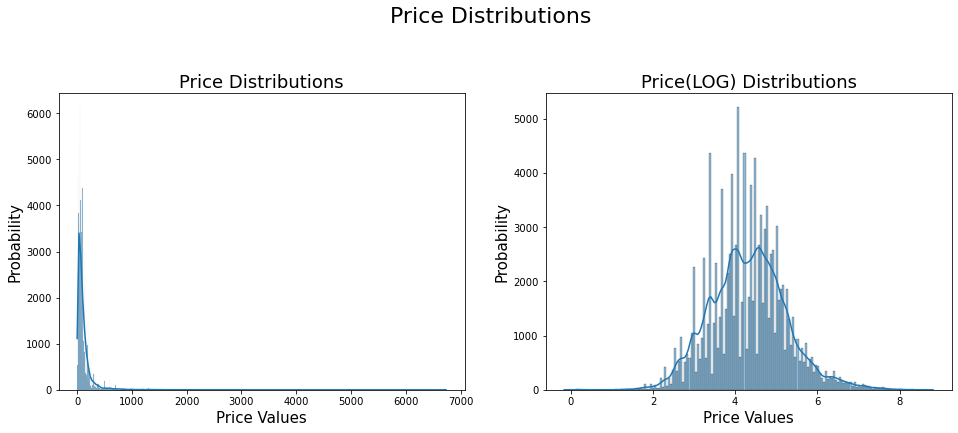

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


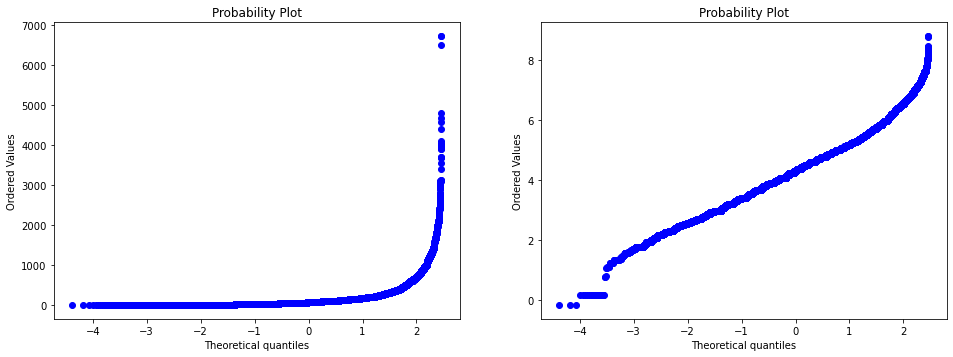

In [13]:
# Getting the histogram and normal probability plot
plt.figure(figsize=(16,12))
plt.suptitle('Price Distributions', fontsize=22)
plt.subplot(221)
g = sns.histplot(df_train['price'], kde=True)
g.set_title("Price Distributions", fontsize=18)
g.set_xlabel("Price Values", fontsize=15)
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.histplot(np.log(df_train['price']), kde=True)
g1.set_title("Price(LOG) Distributions", fontsize=18)
g1.set_xlabel("Price Values", fontsize=15)
g1.set_ylabel("Probability", fontsize=15)

plt.show()

plt.figure(figsize=(16,12))

plt.subplot(221)
res = stats.probplot(df_train['price'], plot=plt, fit=True, rvalue=True);

plt.subplot(222)
res = stats.probplot(np.log(df_train['price']), plot=plt, fit=True, rvalue=True);

plt.show()

Price Distribution: Histogram of a sample from a right-skewed distribution – it looks unimodal and skewed right.

Price Log Distribution: Histogram of a sample from a normal distribution – it looks fairly symmetric and unimodal.

Probability Plot - Price Distribution: Normal probability plot of a sample from a right-skewed distribution – it has an inverted C shape.

Probability Plot - Price Log Distribution: Normal probability plot of a sample from a normal distribution – it looks fairly straight, at least when the few large and small values are ignored.

# Visualization E-commerce Orders Overtime

# **Evolution of E-Commerce Overtime - Amount of orders**

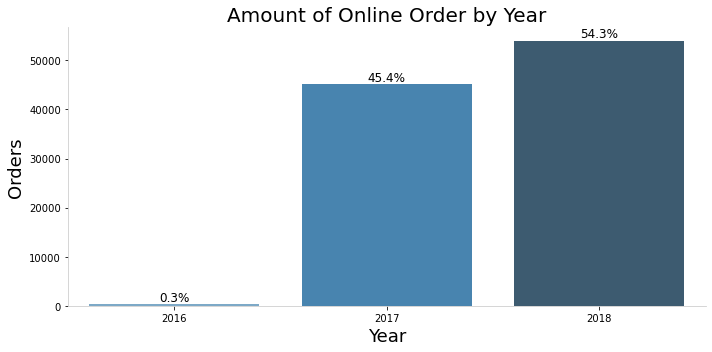

In [14]:
# Preparing the chart
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_year', data=df_orders, palette='Blues_d')
format_spines(ax, right_border=False)

# Showing frequency
ncount = len(df_orders)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom', size=12)

ax.set_title('Amount of Online Order by Year', size=20)
ax.set_ylabel('Orders', size=18)
ax.set_xlabel('Year', size=18)

plt.tight_layout()
plt.show()

The number of orders in 2016 was insignificant, only 0,3% of the total.

Then, we selected the period of interest to try a better performance in the model

# **Evolution of E-Commerce Overtime - Total Sales per day**

In [15]:
df_sale = df_train.groupby('order_purchase_timestamp')['price'].sum().reset_index()
df_sale['order_purchase_timestamp'] = pd.to_datetime(df_sale['order_purchase_timestamp'])
df_sale = df_sale.sort_values('order_purchase_timestamp')
df_sale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88789 entries, 88086 to 8468
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_purchase_timestamp  88789 non-null  datetime64[ns]
 1   price                     88789 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 MB


**Analyzing the outliers**

<Figure size 1800x720 with 0 Axes>

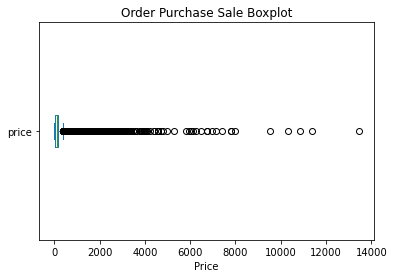

In [16]:
#Data Order Purchase Analysis
plt.figure(figsize=(25,10))
df_sale.plot.box(title='Order Purchase Sale Boxplot', vert=0);
plt.xlabel('Price')
plt.ylabel('');

In [17]:
df_sale.isnull().sum()

order_purchase_timestamp    0
price                       0
dtype: int64

In [18]:
df_previsao = df_sale.set_index('order_purchase_timestamp')
df_previsao.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88789 entries, 2016-09-04 21:15:00 to 2018-10-17 17:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   88789 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


**Test of stationarity**

In [19]:
# Test of stationarity.
# The null hypothesis reject (H0)= the series is not stationary
# If the p-value is less than 0.05, reject H0.

from statsmodels.tsa.stattools import adfuller

result=adfuller(df_previsao.dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-58.10187832360876
p-valor:0.0


#  **Evolution of E-Commerce Overtime - Total Sales per month**

In [20]:
#Resample time-series data to start month.
previsao = df_previsao['price'].resample('MS').mean()
previsao.fillna(df_previsao['price'].mean(), inplace=True)

In [21]:
previsao.round(2)

order_purchase_timestamp
2016-09-01     66.84
2016-10-01    163.80
2016-11-01    160.03
2016-12-01     10.90
2017-01-01    169.71
2017-02-01    152.76
2017-03-01    155.78
2017-04-01    170.71
2017-05-01    158.76
2017-06-01    151.16
2017-07-01    143.83
2017-08-01    150.43
2017-09-01    168.78
2017-10-01    163.21
2017-11-01    171.10
2017-12-01    151.41
2018-01-01    155.04
2018-02-01    150.29
2018-03-01    161.13
2018-04-01    166.15
2018-05-01    171.97
2018-06-01    162.65
2018-07-01    165.94
2018-08-01    155.89
2018-09-01      9.06
2018-10-01      0.00
Freq: MS, Name: price, dtype: float64

In [22]:
previsao2 = previsao.replace(10.90, 160.76)
previsao3 = previsao2.drop(labels=['2018-09-01', '2018-10-01'])
previsao3.round(2)

order_purchase_timestamp
2016-09-01     66.84
2016-10-01    163.80
2016-11-01    160.03
2016-12-01    160.76
2017-01-01    169.71
2017-02-01    152.76
2017-03-01    155.78
2017-04-01    170.71
2017-05-01    158.76
2017-06-01    151.16
2017-07-01    143.83
2017-08-01    150.43
2017-09-01    168.78
2017-10-01    163.21
2017-11-01    171.10
2017-12-01    151.41
2018-01-01    155.04
2018-02-01    150.29
2018-03-01    161.13
2018-04-01    166.15
2018-05-01    171.97
2018-06-01    162.65
2018-07-01    165.94
2018-08-01    155.89
Freq: MS, Name: price, dtype: float64

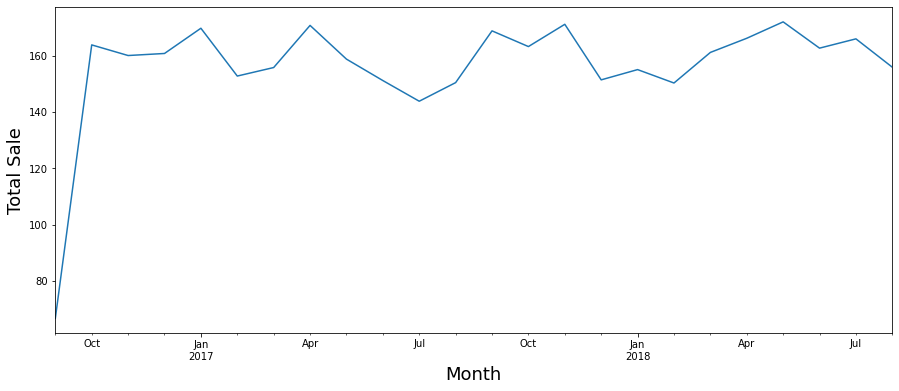

In [23]:
previsao3.plot(figsize=(15, 6))
plt.xlabel("Month", size=18)
plt.ylabel("Total Sale", size=18)
plt.show()

As expected, the week with the order maximum was in the 47th week of 2017, when is the week known as Black Friday in Brazil. The minimum number of orders was in the first week of January 2018, a hangover period for purchases that took place at the end of year.

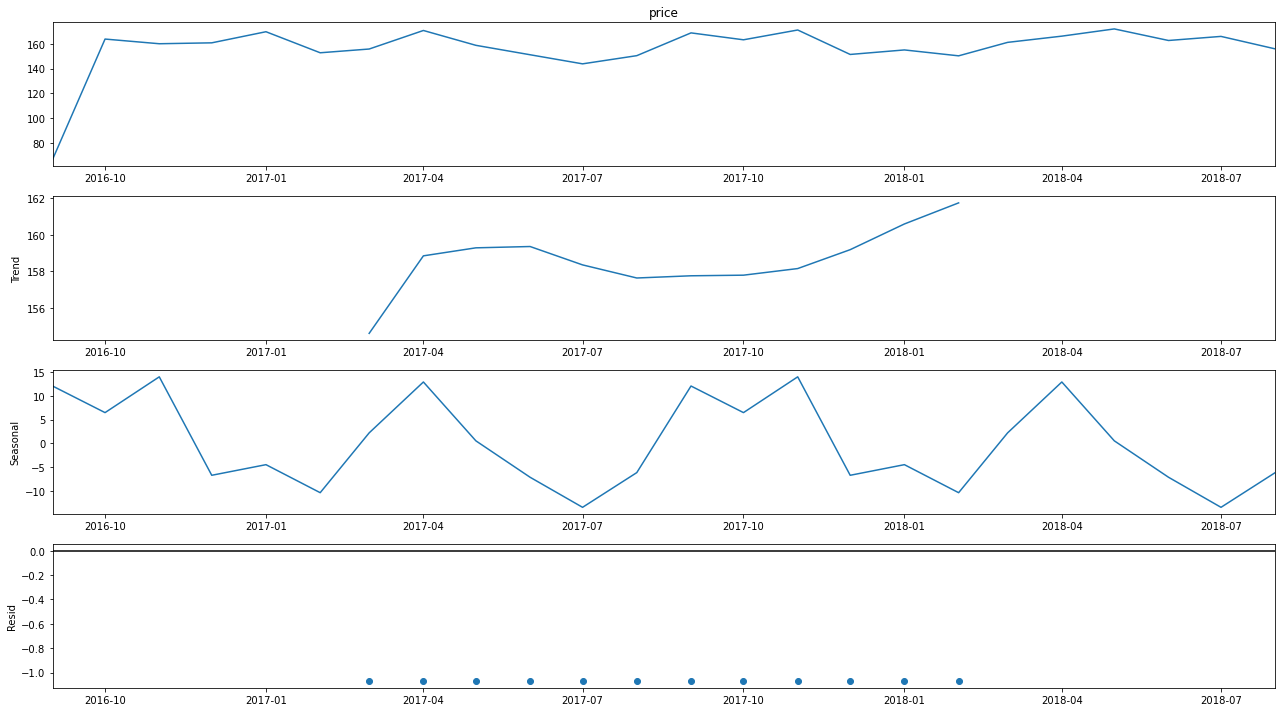

In [24]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(previsao3, model='additive')
fig = decomposition.plot()
plt.show()

In [25]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [26]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(previsao3,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            #enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:312.949470484681
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:302.2333218620751
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:118.64084136954845
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:120.62890755188207
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:275.9970485129678
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:277.99704849162987
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:120.6180151071045
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:122.61827446904101
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:286.0546524204657
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:276.16872549016875
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:120.59945145588634
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:122.61337234379411
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:266.56484161027765
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:267.97831076299485
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:122.6623987365862
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:124.70766405719705
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:210.29248820294248
SARIMAX(0, 1, 0)x(0, 

The above output suggests that the SARIMAX(0, 1, 0)x(0, 1, 0, 12)12 produces the lowest AIC value - AIC:110.35220622507379.

In [27]:
df_previsao = df_sale.set_index('order_purchase_timestamp')

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                   24
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -54.130
Date:                            Sun, 16 Jan 2022   AIC                            110.260
Time:                                    04:27:47   BIC                            110.658
Sample:                                09-01-2016   HQIC                           110.009
                                     - 08-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1100.9148    245.387      4.486      0.000     619.965    1581.865
Ljung-Box (L1) (Q):                

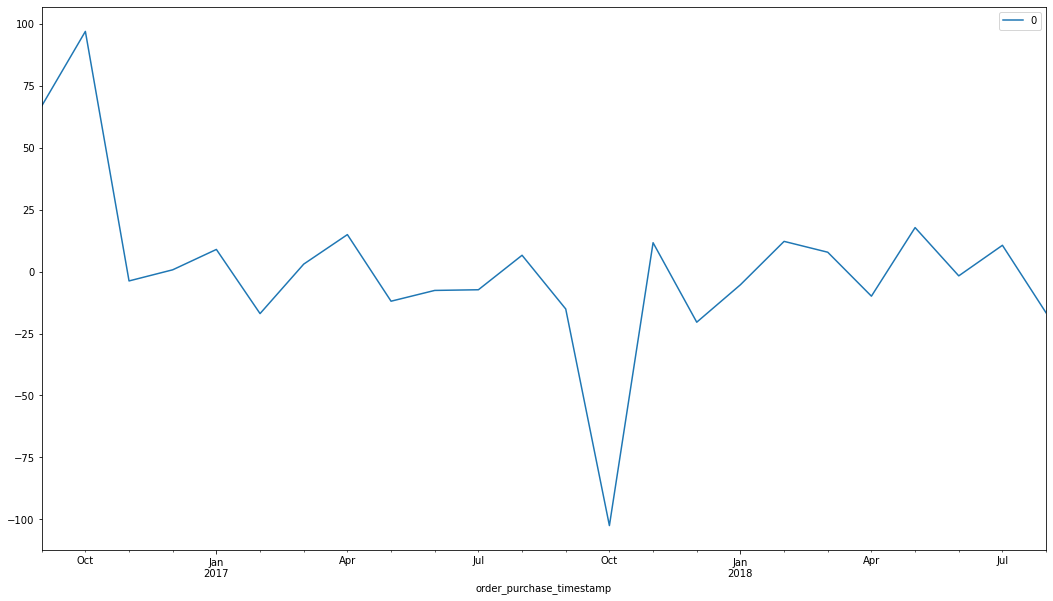

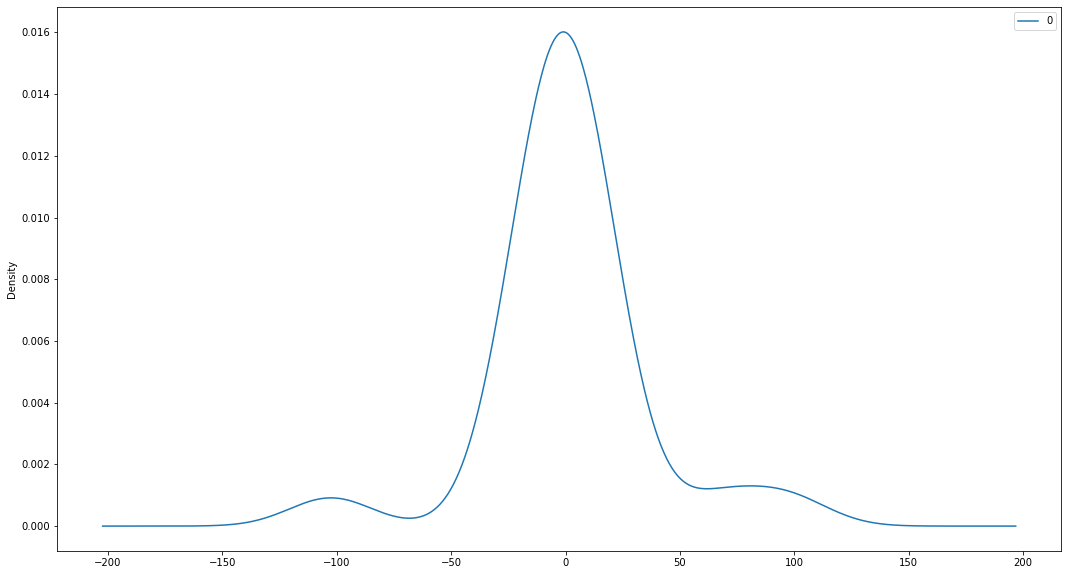

                0
count   24.000000
mean     1.619198
std     34.298111
min   -102.526776
25%    -10.426512
50%     -0.495956
75%     10.881683
max     96.961383


In [28]:
#Now, let's go create a SARIMAX model with seasonality (Arima version with parameters for seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import DataFrame


model_sarimax_previsao = SARIMAX(previsao3, order=(0,1,0), seasonal_order=(0,1,0,12), enforce_invertibility=False)
resultado_sarimax_previsao = model_sarimax_previsao.fit()
# summary of fit model
print(resultado_sarimax_previsao.summary())
resultado_sarimax_previsao.summary()

# line plot of residuals
residuals_previsao = DataFrame(resultado_sarimax_previsao.resid)
residuals_previsao.plot()
plt.show()
# density plot of residuals
residuals_previsao.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals_previsao.describe())

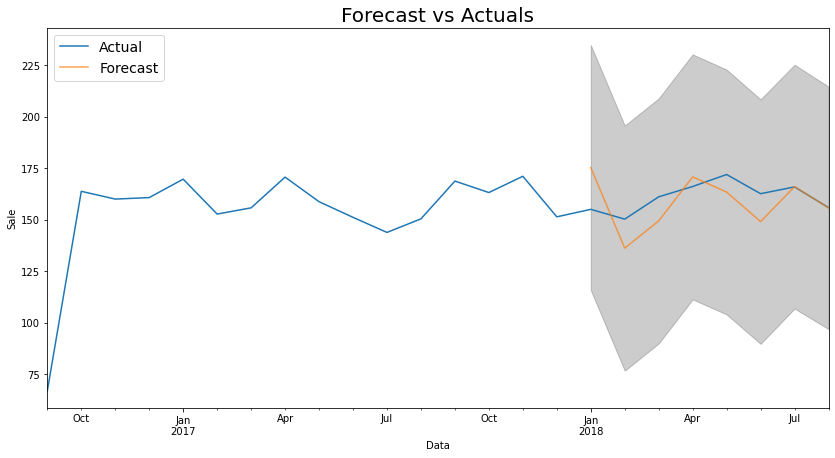

In [29]:
# VALIDATING THE FORECAST

pred_previsao = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred_previsao.conf_int()
ax = previsao3['2016':].plot(label='Actual')
pred_previsao.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data')
ax.set_ylabel('Sale')
plt.title('Forecast vs Actuals', fontsize=20)
plt.legend(loc='upper left', fontsize=14)
plt.show()

From the chart, the SARIMAX(0, 1, 0)x(0, 1, 0, 12) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

In [30]:
previsao_forecasted = pred_previsao.predicted_mean
previsao3_truth = previsao3['2018-01-01':]
mse = ((previsao_forecasted - previsao3_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 128.22


In [31]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 11.32


# 🔮 FINAL FORECAST - BY MONTH

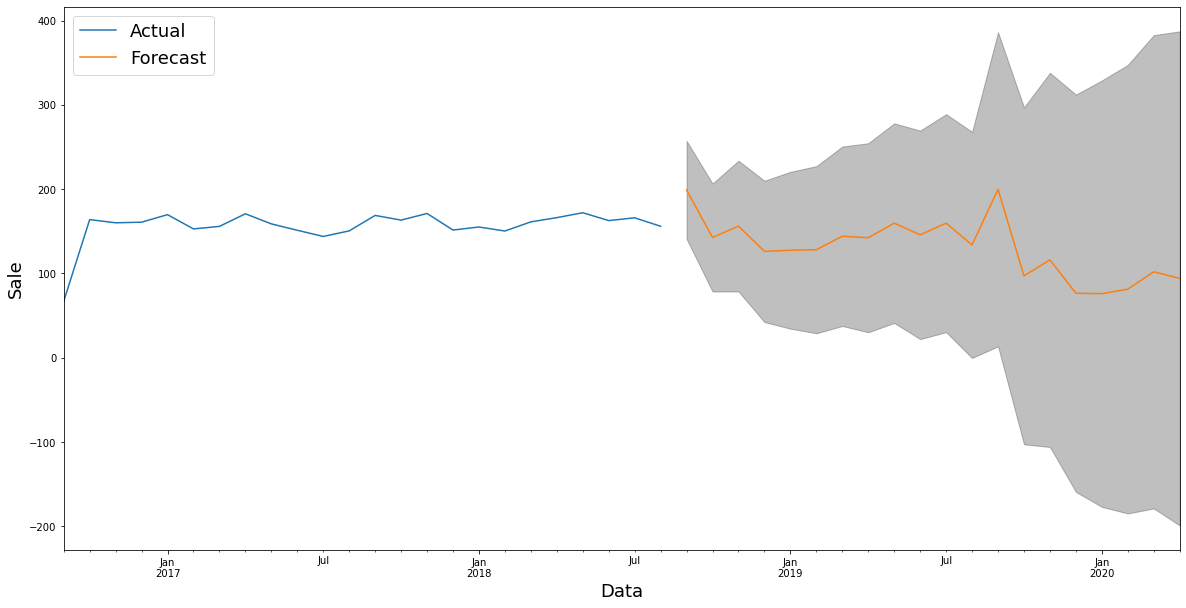

In [32]:
# Let’s forecast for the next 20 months.

pred_uc = results.get_forecast(steps=20)
pred_ci2 = pred_uc.conf_int()
ax = previsao3.plot(label='Actual', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data', fontsize=18)
ax.set_ylabel('Sale', fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.show()

# **Evolution of E-Commerce Overtime - Total Sales per week**

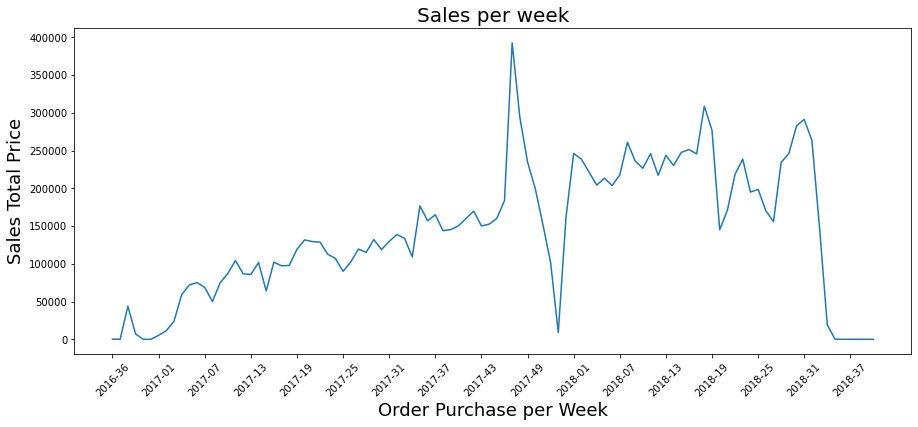

In [33]:
#Sizing the table
plt.subplots(figsize=(15, 6))

# creating a weekly sales total price feature
df_sale['sales_weekly'] = df_sale['order_purchase_timestamp'].dt.strftime('%Y-%U')

# creating an aggregation
total_sales_weekly = df_sale.groupby('sales_weekly', as_index=False).price.sum()
ax = sns.lineplot(x="sales_weekly", y="price", data=total_sales_weekly)
ax.set_title('Sales per week', fontsize=20)
ax.set_ylabel('Sales Total Price', fontsize=18)
ax.set_xlabel('Order Purchase per Week', fontsize=18)
ax.set_xticks(ax.get_xticks()[::6])
plt.xticks(rotation=45);

As expected, the week with the order maximum was in the 47th week of 2017, when is the week known as Black Friday in Brazil. The minimum number of orders was in the first week of January 2018, a hangover period for purchases that took place at the end of year.

In [34]:
#Resample time-series data to start month.
previsao4 = df_previsao['price'].resample('W-MON').mean()
previsao4.fillna(df_previsao['price'].mean(), inplace=True)

In [35]:
previsao4.round(2)

order_purchase_timestamp
2016-09-05     66.19
2016-09-12    160.03
2016-09-19     67.48
2016-09-26    160.03
2016-10-03     62.61
               ...  
2018-09-24      0.00
2018-10-01      0.00
2018-10-08      0.00
2018-10-15    160.03
2018-10-22      0.00
Freq: W-MON, Name: price, Length: 112, dtype: float64

In [36]:
previsao5=previsao4.iloc[:-7]
previsao_w = previsao5.replace({0.000000: 160.759775,10.900000:160.759775})

In [37]:
previsao_w[:20]

order_purchase_timestamp
2016-09-05     66.195000
2016-09-12    160.033904
2016-09-19     67.485000
2016-09-26    160.033904
2016-10-03     62.608889
2016-10-10    167.371262
2016-10-17    160.033904
2016-10-24    160.759775
2016-10-31    160.033904
2016-11-07    160.033904
2016-11-14    160.033904
2016-11-21    160.033904
2016-11-28    160.033904
2016-12-05    160.033904
2016-12-12    160.033904
2016-12-19    160.033904
2016-12-26    160.759775
2017-01-02    160.033904
2017-01-09    140.267021
2017-01-16    174.959213
Freq: W-MON, Name: price, dtype: float64

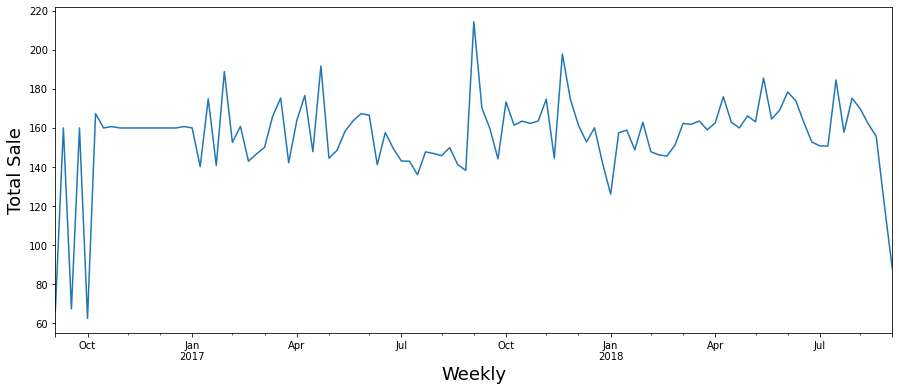

In [38]:
previsao_w.plot(figsize=(15, 6))
plt.xlabel("Weekly", size=18)
plt.ylabel("Total Sale", size=18)
plt.show()

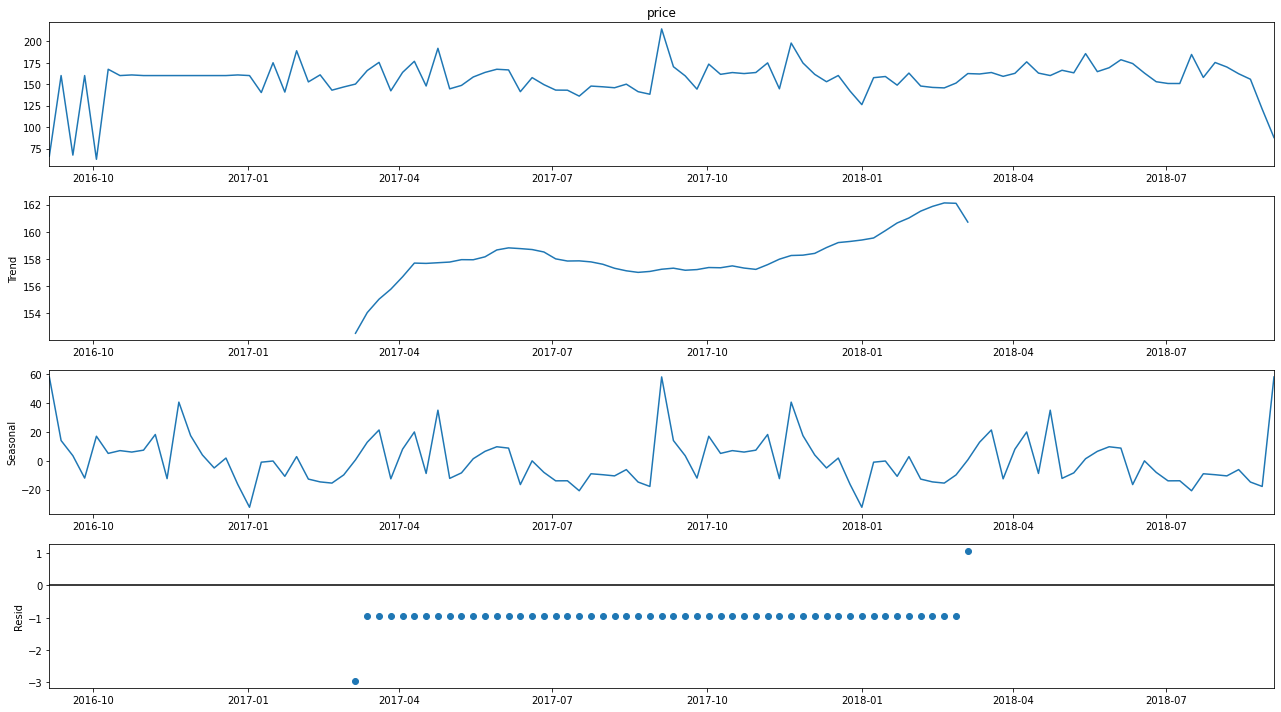

In [39]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(previsao_w, model='additive')
fig = decomposition.plot()
plt.show()

In [40]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            modweek = sm.tsa.statespace.SARIMAX(previsao_w,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            #enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = modweek.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1362.329480904278
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1260.8494017438197
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:891.4494286065012
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:869.6858192841861
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1046.8358282795657
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1026.7582504201441
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:875.0335549226802
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:869.8997486238467
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1257.05288484543
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1180.805677127986
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:892.3391626299539
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:871.2646654983256
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1044.6606278135816
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1026.2242839214653
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:876.8613414765478
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:871.710694032801
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:993.4456000811064
SARIMAX(0, 1, 0)x(0, 0, 1, 1

The above output suggests that the SARIMAX(1, 1, 1)x(0, 1, 1, 12)12 produces the lowest AIC:851.3615242732058

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -421.115
Date:                            Sun, 16 Jan 2022   AIC                            850.230
Time:                                    04:27:57   BIC                            860.317
Sample:                                09-05-2016   HQIC                           854.301
                                     - 09-03-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5414      0.107     -5.041      0.000      -0.752      -0.331
ma.L1         -0.3054      0.141   

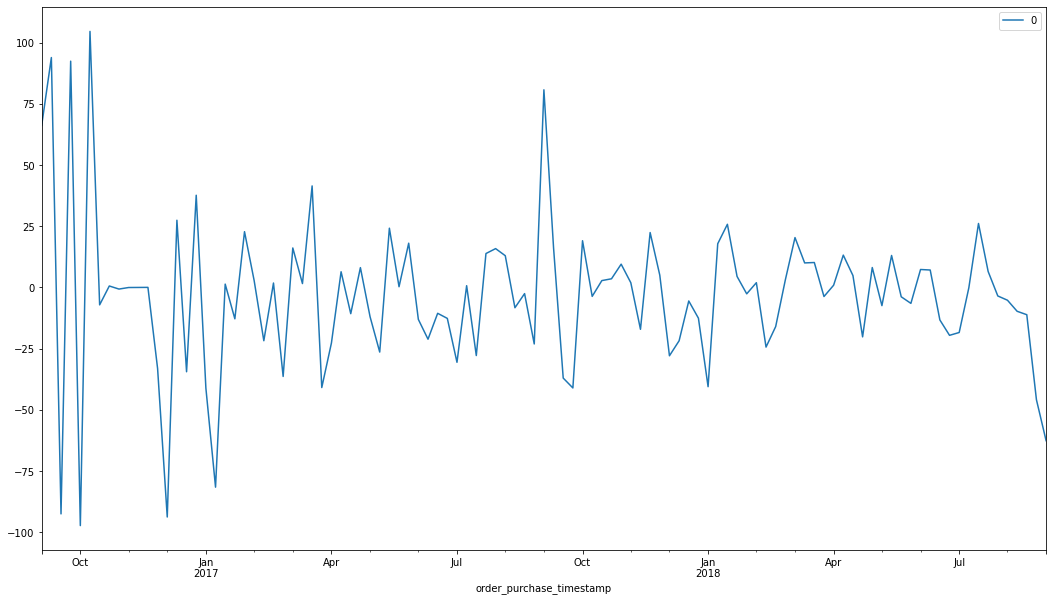

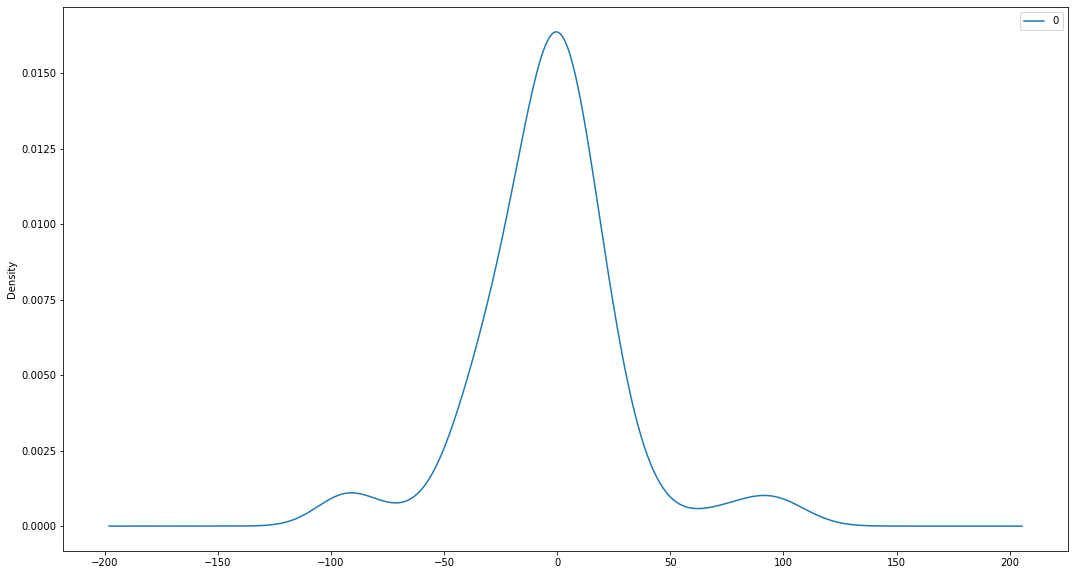

                0
count  105.000000
mean    -3.259642
std     32.420187
min    -97.241462
25%    -18.398886
50%     -0.131113
75%      9.510430
max    104.555083


In [41]:
#Now, let's go create a SARIMAX model with seasonality (Arima version with parameters for seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import DataFrame


model_sarimax_previsao = SARIMAX(previsao_w, order=(1,1,1), seasonal_order=(0,1,1,12), enforce_invertibility=False)
resultado_sarimax_previsao = model_sarimax_previsao.fit()
# summary of fit model
print(resultado_sarimax_previsao.summary())
resultado_sarimax_previsao.summary()

# line plot of residuals
residuals_previsao = DataFrame(resultado_sarimax_previsao.resid)
residuals_previsao.plot()
plt.show()
# density plot of residuals
residuals_previsao.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals_previsao.describe())

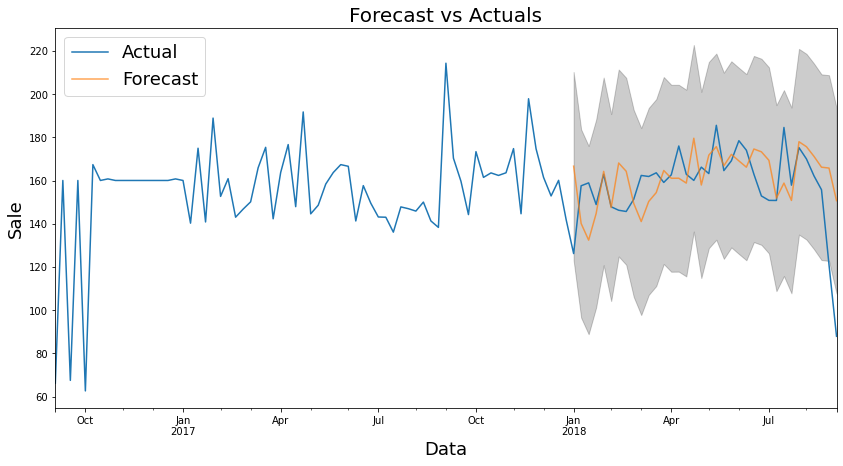

In [42]:
# VALIDATING THE FORECAST - weekly

pred_w = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred_w.conf_int()
ax = previsao_w['2016':].plot(label='Actual')
pred_w.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data', fontsize=18)
ax.set_ylabel('Sale', fontsize=18)
plt.title('Forecast vs Actuals', fontsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()

In [43]:
previsao_forecasted = pred_w.predicted_mean
previsao_w_truth = previsao_w['2018-01-01':]
mse = ((previsao_forecasted - previsao_w_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 361.51


In [44]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 19.01


# 🔮 FINAL FORECAST - BY WEEK

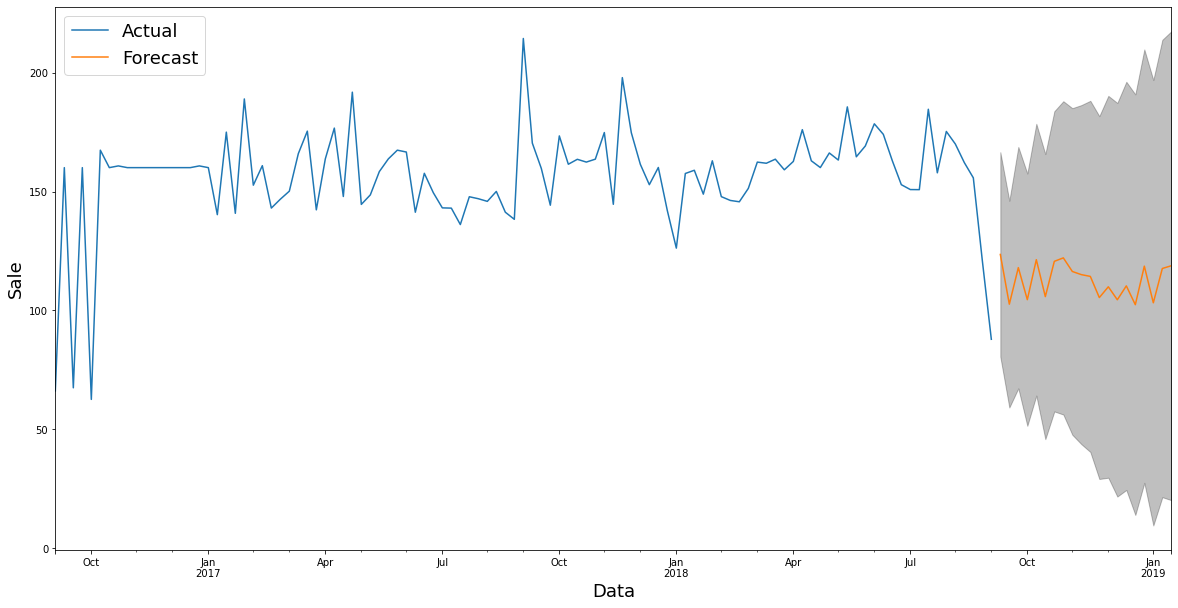

In [45]:
# # Let’s forecast for the next 20 weeks.

pred_uc = results.get_forecast(steps=20)
pred_ci2 = pred_uc.conf_int()
ax = previsao_w.plot(label='Actual', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data', fontsize=18)
ax.set_ylabel('Sale', fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.show()

# **Customer's State Distribution**

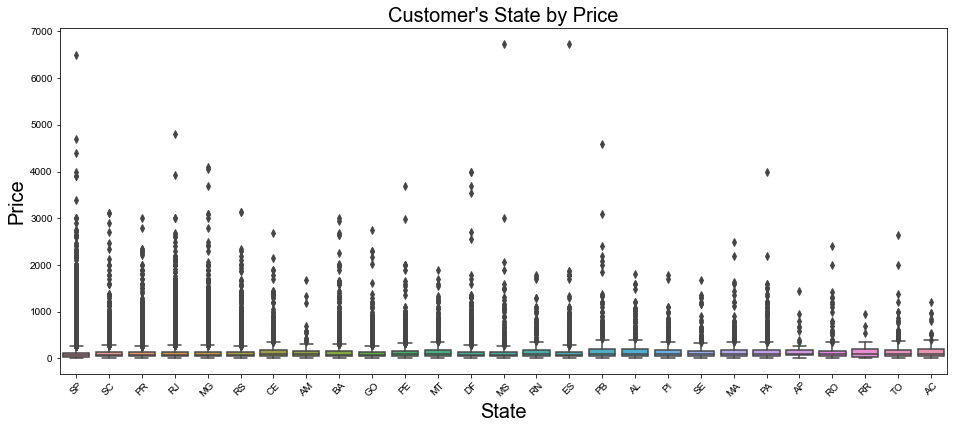

In [46]:
plt.figure(figsize=(35,14))

plt.subplot(221)
sns.set(font_scale=1.5) 
g2 = sns.boxplot(x='customer_state', y='price', 
                 data=df_train[df_train['price'] != -1])
g2.set_title("Customer's State by Price", fontsize=20)
g2.set_xlabel("State", fontsize=20)
g2.set_ylabel("Price", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.show()

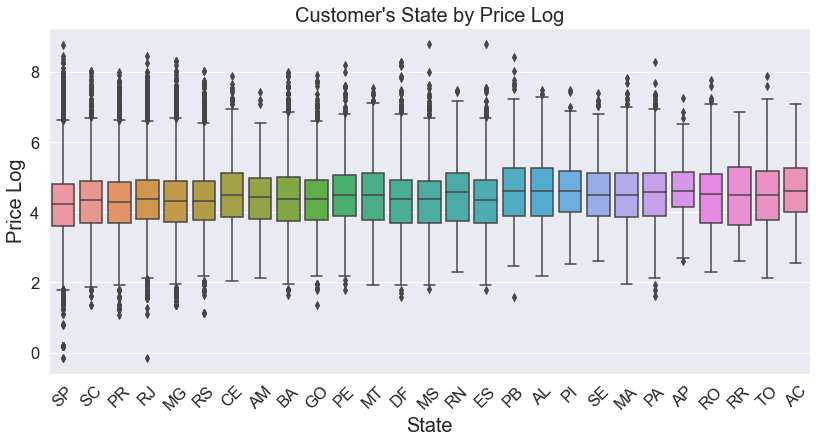

In [47]:
plt.figure(figsize=(30,14))
df_train['price_log'] = np.log(df_train['price'])

plt.subplot(221)
sns.set(font_scale=1.5) 
g2 = sns.boxplot(x='customer_state', y='price_log', 
                 data=df_train[df_train['price'] != -1])
g2.set_title("Customer's State by Price Log", fontsize=20)
g2.set_xlabel("State", fontsize=20)
g2.set_ylabel("Price Log", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.show()

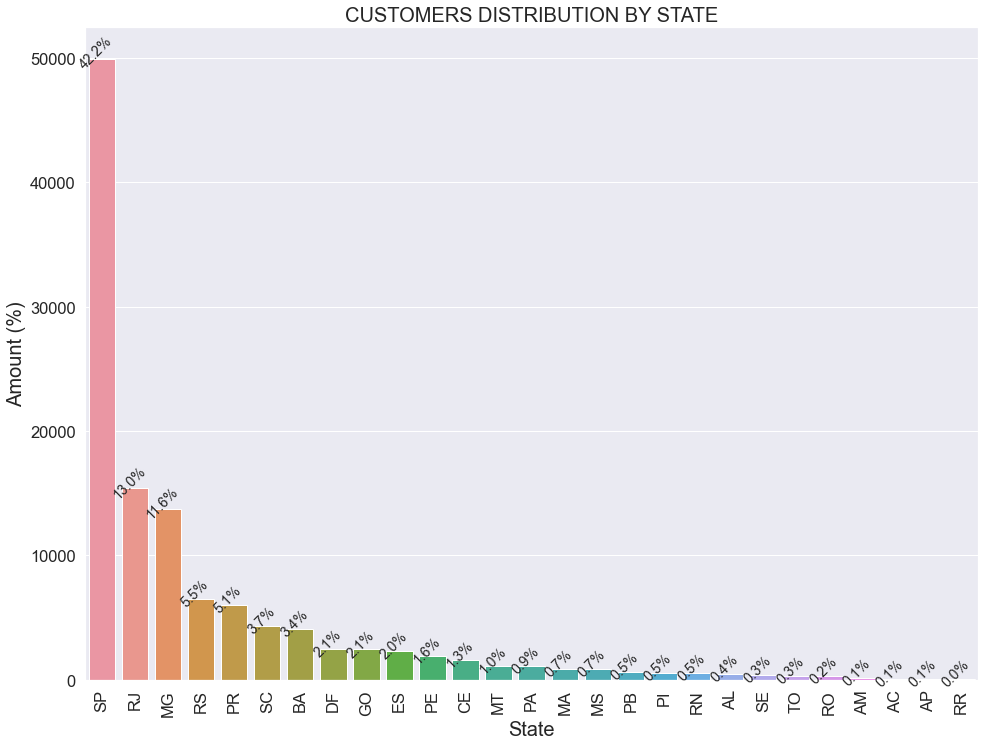

In [48]:
plt.figure(figsize=(16,12))

ax = sns.countplot(x='customer_state', data=df_train, orient='h', order=df_train['customer_state'].value_counts().index)
ax.set_title("CUSTOMERS DISTRIBUTION BY STATE", fontsize=20)
ax.set_xlabel("State", fontsize=20)
ax.set_ylabel("Amount (%)", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sizes = []
total=len(df_train)

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=14, rotation=45)
    

plt.show()

# **References:**

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python

https://www.kaggle.com/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp

https://www.linkedin.com/pulse/previs%25C3%25A3o-de-vendas-com-an%25C3%25A1lise-s%25C3%25A9ries-temporais-everton-s-paula/?trackingId=fRvgTUaEQCmaZhLGDBdG7A%3D%3D

https://github.com/ledmaster/notebooks_tutoriais/blob/master/live12_timeseries_prophet/nb1.ipynb

https://facebook.github.io/prophet/docs/quick_start.html#python-api

https://github.com/Pedro-Prestes/learning/blob/master/Aula_010_S%C3%A9ries_Temporais_com_Prophet.ipynb